1. На основе учебного ноутбука проведите финальную подготовку данных. Измените количество сегментирующих классов с `16` на `7`:
  - 0_класс - FLOOR
  - 1_класс - CEILING
  - 2_класс - WALL
  - 3_класс - APERTURE, DOOR, WINDOW
  - 4_класс - COLUMN, RAILINGS, LADDER
  - 5_класс - INVENTORY
  - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Изучите внимательно особенности `U-net`, определите в чем принципиальное отличие  `U-net `  и   `simpleUnet` из учебного ноутбука.

3. Доработайте `simpleUnet` с учетом особенностей `U-net `. Обучите модель на 100 эпохах и визуализируйте результат.

**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

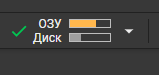

Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка

### Импорт библиотек

In [1]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

### Загрузка датасета

грузим и распаковываем архив картинок

In [2]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

!unzip -q 'construction_256x192.zip' # распоковываем архив

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_256x192.zip
100%|██████████| 214M/214M [00:16<00:00, 12.6MB/s]


### Предварительная подготовка данных


In [3]:
# Глобальные параметры

IMG_WIDTH = 192               # Ширина картинки
IMG_HEIGHT = 256             # Высота картинки
NUM_CLASSES = 16              # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

Загрузим оригинальные изображения (код из лекции):

In [4]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images))

cur_time = time.time() # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images))

Обучающая выборка загружена. Время загрузки: 0.35c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.02c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [5]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments))

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments))

Обучающая выборка загружена. Время загрузки: 0.25c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.01c
Количество изображений:  100


## Решение

In [6]:
# Новые классы
FLOOR = (100, 100, 100)         # Пол (Серый)
CEILING = (0, 0, 100)           # Потолок (Синий)
WALL = (0, 100, 0)              # Стена (Зелёный)
APERTURE = (0, 100, 100)        # Проем (Темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (Бордовый)
WINDOW = (100, 100, 0)          # Окно (Золотой)
COLUMN = (100, 0, 0)            # Колонна (Красный)
RAILINGS = (0, 200, 0)          # Перила (Светло-зелёный)
LADDER = (0, 0, 200)            # Лестница (Светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (Розовый)
LAMP = (200, 200, 0)            # Лампа (Жёлтый)
WIRE = (0, 100, 200)            # Провод (Голубой)
BEAM = (100, 0, 200)            # Балка (Фиолетовый)
EXTERNAL = (200, 200, 200)      # Внешний мир (Светло-серый)
BATTERY = (200, 0, 0)           # Батареи (Светло-красный)
PEOPLE = (0, 200, 200)          # Люди (Бирюзовый)

In [7]:
# Список меток семи классов
NEW_CLASS_LABELS = (FLOOR, CEILING, WALL, APERTURE, COLUMN, INVENTORY, LAMP)
NUM_CLASSES = 7  # Теперь классов 7

# Функция преобразования цветного изображения в метки классов (7 классов)
def rgb_to_labels_7class(image_list):
    result = []
    for d in image_list:
        sample = np.array(d)
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')
        # FLOOR
        y[np.where(np.all(sample == FLOOR, axis=-1))] = 0
        # CEILING
        y[np.where(np.all(sample == CEILING, axis=-1))] = 1
        # WALL
        y[np.where(np.all(sample == WALL, axis=-1))] = 2
        # APERTURE, DOOR, WINDOW
        y[np.where(np.all(sample == APERTURE, axis=-1))] = 3
        y[np.where(np.all(sample == DOOR, axis=-1))] = 3
        y[np.where(np.all(sample == WINDOW, axis=-1))] = 3
        # COLUMN, RAILINGS, LADDER
        y[np.where(np.all(sample == COLUMN, axis=-1))] = 4
        y[np.where(np.all(sample == RAILINGS, axis=-1))] = 4
        y[np.where(np.all(sample == LADDER, axis=-1))] = 4
        # INVENTORY
        y[np.where(np.all(sample == INVENTORY, axis=-1))] = 5
        # LAMP, WIRE, BEAM, EXTERNAL, BATTERY, PEOPLE
        y[np.where(np.all(sample == LAMP, axis=-1))] = 6
        y[np.where(np.all(sample == WIRE, axis=-1))] = 6
        y[np.where(np.all(sample == BEAM, axis=-1))] = 6
        y[np.where(np.all(sample == EXTERNAL, axis=-1))] = 6
        y[np.where(np.all(sample == BATTERY, axis=-1))] = 6
        y[np.where(np.all(sample == PEOPLE, axis=-1))] = 6
        result.append(y)
    return np.array(result)

In [8]:
# Функция преобразования семантических масок (7 классов) в RGB-изображение с цветовой кодировкой
def labels_to_rgb_7class(image_list):
    result = []
    for y in image_list:
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')
        # FLOOR (Серый)
        temp[np.where(np.all(y==0, axis=-1))] = FLOOR
        # CEILING (Синий)
        temp[np.where(np.all(y==1, axis=-1))] = CEILING
        # WALL (Зеленый)
        temp[np.where(np.all(y==2, axis=-1))] = WALL
        # APERTURE (Тёмно-бирюзовый)
        temp[np.where(np.all(y==3, axis=-1))] = APERTURE
        # COLUMN (Красный)
        temp[np.where(np.all(y==4, axis=-1))] = COLUMN
        # INVENTORY (Розовый)
        temp[np.where(np.all(y==5, axis=-1))] = INVENTORY
        # LAMP (Жёлтый)
        temp[np.where(np.all(y==6, axis=-1))] = LAMP
        result.append(temp)
    return np.array(result)

In [9]:
# Улучшенная реализация U-Net архитектуры для семантической сегментации
def improved_simple_unet(class_count, input_shape):
    img_input = Input(input_shape)
    # Block 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(block_1_out)

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(block_2_out)

    # Block 3
    x = Conv2D(128, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(block_3_out)

    # Block 4
    x = Conv2D(256, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(block_4_out)

    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = concatenate([x, block_3_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = concatenate([x, block_2_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = concatenate([x, block_1_out])
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)
    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

In [10]:
# Входные изображения в numpy массивы
x_train = np.array([image.img_to_array(img) for img in train_images])
x_val = np.array([image.img_to_array(img) for img in val_images])

# Сегментированные изображения в метки семи классов
y_train = rgb_to_labels_7class(train_segments)
y_val = rgb_to_labels_7class(val_segments)

In [11]:
import tensorflow as tf
with tf.device('/GPU:0'):
    # Улучшенная модель
    model_improved = improved_simple_unet(NUM_CLASSES, (IMG_WIDTH, IMG_HEIGHT, 3))
    model_improved.summary()
    # Обучение
    history = model_improved.fit(x_train, y_train,
                                epochs=100, batch_size=32,
                                validation_data=(x_val, y_val))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 192, 256,  │        896 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 192, 256,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 192, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 192, 256,  │      9,248 │ activation[0][0]  │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256,  │        128 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 192, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 96, 128,   │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 96, 128,   │     18,496 │ max_pooling2d[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        256 │ block2_conv1[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 96, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 96, 128,   │     36,928 │ activation_2[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        256 │ block2_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 96, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 48, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 48, 64,    │     73,856 │ max_pooling2d_1[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 64,    │        512 │ block3_conv1[0][

 Total params: 3,183,815 (12.15 MB)

 Trainable params: 3,179,975 (12.13 MB)

 Non-trainable params: 3,840 (15.00 KB)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 104s 893ms/step - loss: 1.3586 - sparse_categorical_accuracy: 0.5200 - val_loss: 2.1716 - val_sparse_categorical_accuracy: 0.2142
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 404ms/step - loss: 0.9342 - sparse_categorical_accuracy: 0.6770 - val_loss: 1.4078 - val_sparse_categorical_accuracy: 0.4696
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 397ms/step - loss: 0.8631 - sparse_categorical_accuracy: 0.7029 - val_loss: 1.2205 - val_sparse_categorical_accuracy: 0.5615
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 402ms/step - loss: 0.7786 - sparse_categorical_accuracy: 0.7323 - val_loss: 1.3844 - val_sparse_categorical_accuracy: 0.5405
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 397ms/step - loss: 0.7548 - sparse_categorical_accuracy: 0.7389 - val_loss: 1.0791 - val_sparse_categorical_accuracy: 0.6290
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 397ms/step - loss: 0.7076 - sparse_categorical_accuracy: 0.7586 - val_loss: 1.1712 - val_sparse_categorical_accuracy

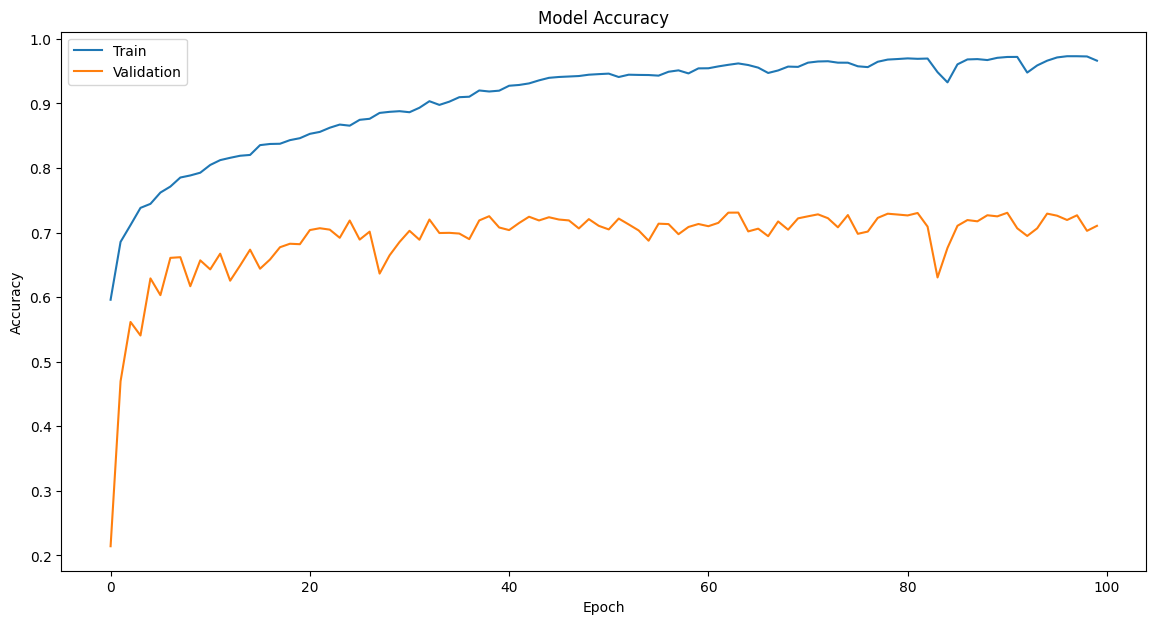

In [12]:
# Графики обучения
plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

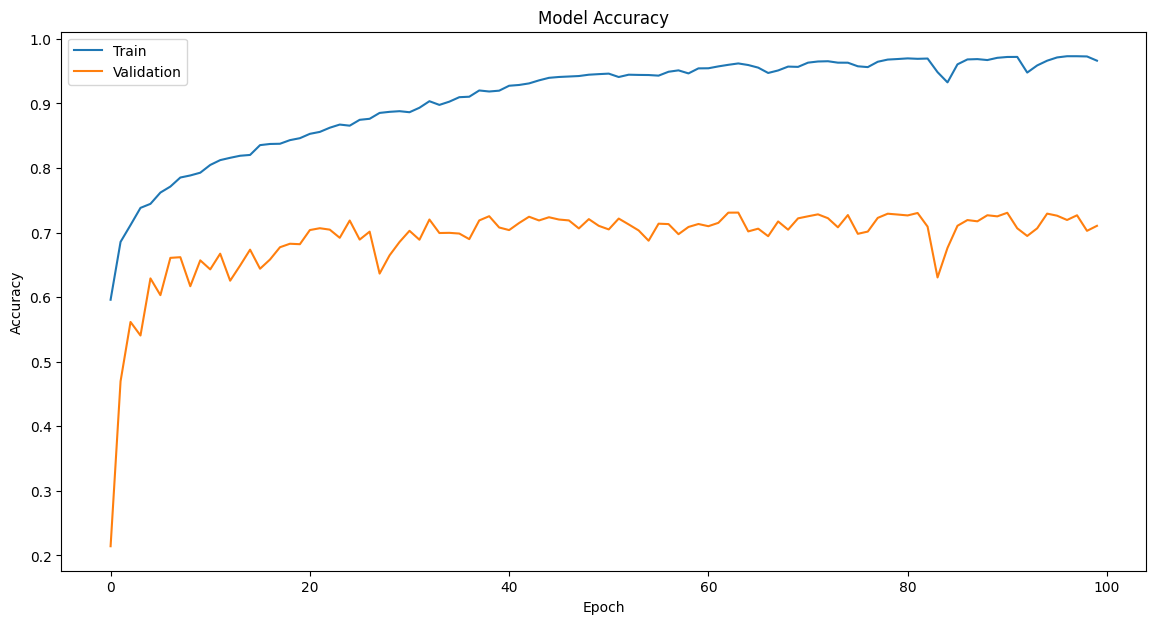

In [13]:
# Визуализация
def process_images_7class(model, count=1):
    indexes = np.random.randint(0, len(x_val), count)
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)
    orig = labels_to_rgb_7class(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 15))
    for i in range(count):
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1, i].axis('off')
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2, i].axis('off')
    plt.show()

# Графики обучения
plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


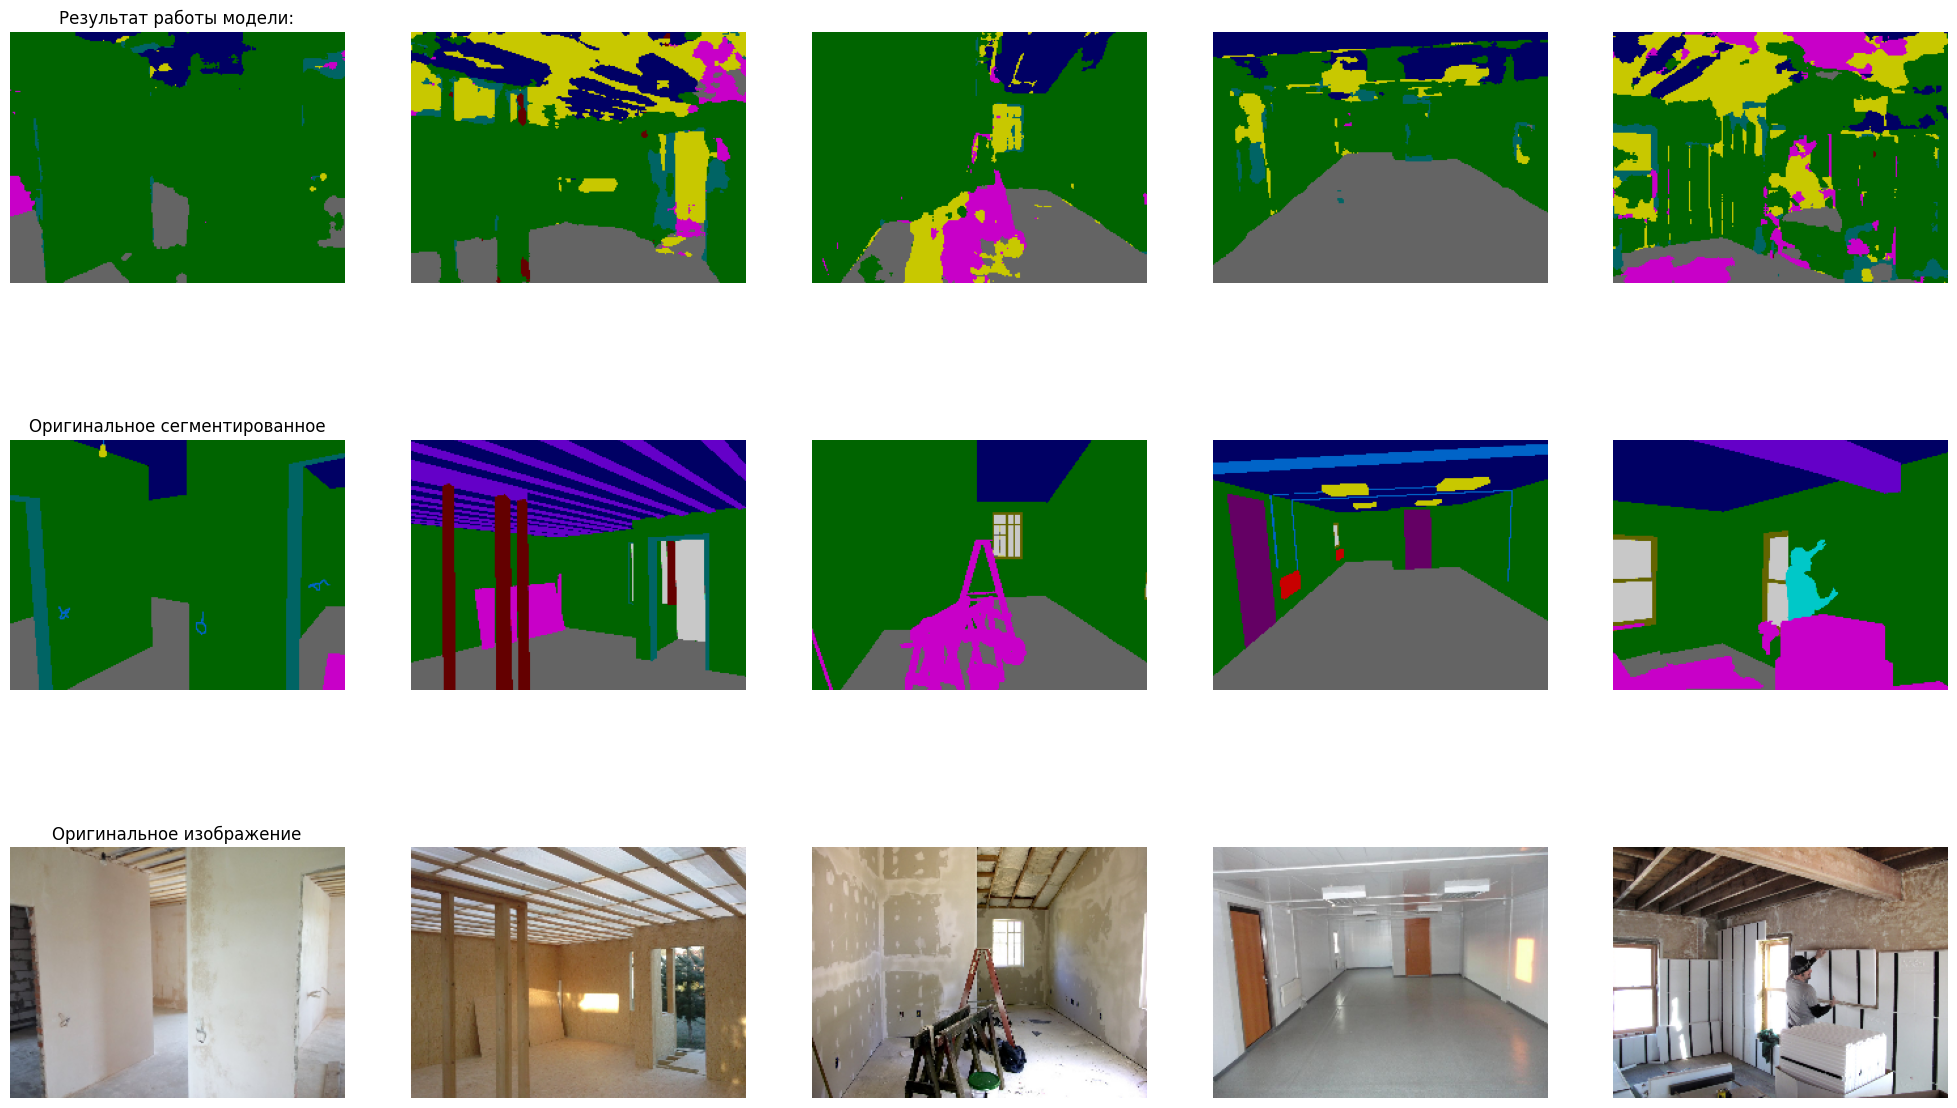

In [14]:
# Результаты сегментации
process_images_7class(model_improved, 5)